In [1]:
import numpy as np
from cvxopt import matrix, solvers, log, exp
import matplotlib.pyplot as plt

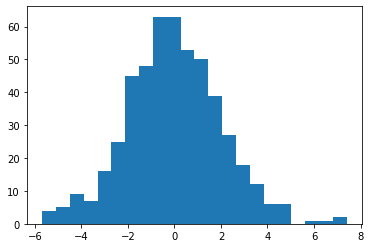

In [2]:
N = 50
T = 10

rank = 5

U_true = np.random.randn(N, rank)
V_true = np.random.randn(T, rank)

R_true = U_true @ V_true.T + 0.05 * np.random.randn(N, T)

plt.hist(R_true.flatten(), bins=np.int32(np.sqrt(N * T)))

C = 5 * np.ones(T)

In [3]:
def solving_system(R, C, reg=1e-5, init_sol = None):
    N, T = R.shape
    A1 = np.zeros((N, N * T))
    for i in range(N):
        A1[i, i * T:(i + 1) * T] = np.ones((T))

    A2 = np.zeros((T, N * T))
    for i in range(T):
        A2[i, i:N * T:T] = np.ones((N))
      
    A = np.concatenate((A1, A2, -1 * np.identity(N * T)))
    
    c = -1 * R.reshape((N * T, 1))

    b = np.concatenate((np.ones(N), C, np.zeros(N * T)))
      
    P = reg * np.identity(N * T)
    solvers.options['show_progress'] = False
    sol = solvers.qp(matrix(P, tc='d'), matrix(c, tc='d'), matrix(A, tc='d'), matrix(b, tc='d'), initvals = init_sol)
    x_sys = np.array(sol['x']).reshape((N, T))
    q_sys = np.array(sol['z'])
    return x_sys, q_sys, sol

In [4]:
x, q, _ = solving_system(R_true, C)

5
135.30259618480562


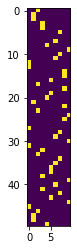

In [5]:
x = np.int32(x > 0.5)
plt.imshow(x)
print(np.max(np.sum(x, axis=0)))
print(np.sum(x * R_true))

8.0
146.72521180851152


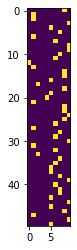

In [6]:
max_ind = np.argmax(R_true, axis=1)
x_without_C = np.zeros((N, T))
x_without_C[np.arange(N), max_ind] = 1
plt.imshow(x_without_C)
print(np.max(np.sum(x_without_C, axis=0)))
print(np.sum(x_without_C * R_true))

In [17]:
alpha = 2

data_sum = np.zeros((N, T))
data_counts = np.zeros((N, T))
    
def update_ucb(observations):

    for obs in observations:
        data_sum[obs[0], obs[1]] += obs[2]
        data_counts[obs[0], obs[1]] += 1
        
#     print(data_counts)
            
    rand = np.random.randn(N, T)
    data_sum[data_counts == 0] = 10 + 0.01 * rand[data_counts == 0]
    data_counts[data_counts == 0] = 1
    
    R_UCB = data_sum / data_counts
    std = alpha / np.sqrt(data_counts)
        
    return R_UCB + std

In [18]:
is_mask_feasible = False
while not is_mask_feasible:
    initial_mask = np.zeros((N, T))
    for i in range(N):
        j = np.random.choice(T)
        initial_mask[i, j] = 1

    if np.min(np.sum(initial_mask, axis=0)) > 0:
        is_mask_feasible = True
        
observations = []
for i in range(N):
    for j in range(T):
        if initial_mask[i, j] == 1:
            observations.append((i, j, R_true[i, j] + np.random.randn()))

In [19]:
horizon = 500

history = np.zeros(horizon)
prev_sol = None

for t in range(horizon):
    
    R_UCB = update_ucb(observations)
    observations = []

#     print(np.linalg.norm(R_UCB))

    x_UCB, _, prev_sol = solving_system(R_UCB, C)
            
    x_UCB = np.int32(x_UCB > 0.5)

#     plt.imshow(x_UCB)
#     plt.show()
    if t % 100 == 0:
        print('Iter ', t)
        print(np.max(np.sum(x_UCB, axis=0)))
        print(np.sum(x_UCB, axis=0))
        print(np.sum(x_UCB * R_true))
    
    history[t] = np.sum(x_UCB * R_true)

    for i in range(N):
        for j in range(T):
            if x_UCB[i, j] == 1:
                observations.append((i, j, R_true[i, j] + np.random.randn()))

Iter  0
5
[5 5 5 5 5 5 5 5 5 5]
4.964271556817239
Iter  100
5
[5 5 5 5 5 5 5 5 5 5]
119.70141617625895
Iter  200
5
[5 5 5 5 3 5 5 5 5 5]
133.66609665367605
Iter  300
5
[5 5 5 5 3 5 5 5 5 5]
134.64503832121085
Iter  400
5
[5 5 5 5 3 5 5 5 5 5]
134.6840462221283


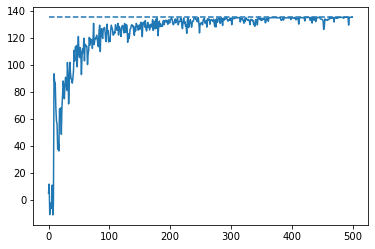

In [20]:
plt.plot(np.arange(horizon), history)
plt.hlines(np.sum(x * R_true), 0, horizon, linestyles='dashed')

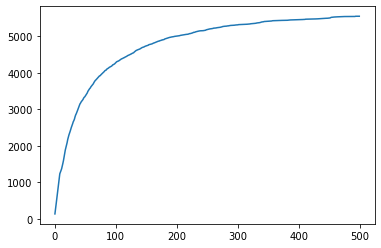

In [21]:
plt.plot(np.arange(horizon), np.cumsum(np.sum(x * R_true) - history))